# Tutorial 2b: *Single-Point Visualizations*

This tutorial is an introduction to analyzing results from a single-point simulation.  It uses results from the case you ran in the 2a Tutorial, but you don't have to wait for those runs to complete before doing this tutorial too. We've prestaged model results from this simulation in a shared directory. This way, you can get started on analyzing simulations results before your simulations finish running. We also ran this case for longer (10 years instead of 1), so that we have more data to work with.

## In this tutorial

The tutorial has several objectives: 
1. Increase familiarity with Jupyter Notebooks
2. Increase knowledge of python packages and their utilities
3. Visualize output from a single-point CTSM simulation.

***
**This tutorial uses a Jupyter Notebook.** A Jupyter Notebook is an interactive computing environment that enables the creation and sharing of documents that contain discrete cells of text or documentation and executable code, including plots. It allows users to access, run, and edit the code in a browser. To interact with this notebook:

- Execute or "run" cells of executable code (cells denoted with '[ ]:') using the play button in the menu at the top (see below image)

- The results of running code, such as plots, will appear below that cell

- Each step must be followed in order, otherwise you may encounter errors

![run cell](https://problemsolvingwithpython.com/02-Jupyter-Notebooks/images/run_cell.png)

For more information on Jupyter notebooks please see the [Jupyter Notebook Quick Start Guide](https://jupyter-notebook-beginner-guide.readthedocs.io/en/latest/what_is_jupyter.html). 


<div class="alert alert-block alert-info">
<b>NOTE:</b> In Day 2a, executable code blocks used a Bash shell, or had to be executed on the command-line.  In this tutorial, we will be using Python code, and you should directly execute the contents of code blocks by running individual cells in this Jupyter notebook, similar to the Day 0b <i>Run NEON</i> tutorial.
</div>

***

*We'll start by loading some packages*

In [1]:
import os

import xarray as xr
import functools
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

<div class="alert alert-block alert-info">

<b>NOTE:</b>  This example largely uses features of xarray and 
    matplotlib packages. We won't go into the basics 
    of python or features in these packages, but there are lots of 
    resources to help get you started. Some of these are listed below. 

</div>

- [NCAR python tutorial](https://ncar.github.io/python-tutorial/tutorials/yourfirst.html), which introduces python, the conda package manager, and more on github.
- [NCAR ESDS tutorial series](https://ncar.github.io/esds/blog/tag/python-tutorial-series/), features several recorded tutorials on a wide variety of topics.
- [GeoCAT examples](https://geocat-examples.readthedocs.io/en/latest/), with some nice plotting examples

***

## 1. Reading and formatting data

### 1.1 Find the correct directories and file names

In [2]:
#path = '/scratch/shared/day2'       # path to archived simulations
path = '/glade/scratch/afoster/archive'
case = 'I2000_CTSM_singlept'        # case name
years = list(range(2001, 2011, 1))  # look at 10 years of data
months = list(range(1, 13, 1))      # we want all months

# build a list of file names based on the year and month
file_names = [f"{case}.clm2.h0.{str(year)}-{str(month).rjust(2, '0')}.nc"
              for year in years for month in months]

# create their full path
full_paths = [os.path.join(path, case, 'lnd/hist', fname) for fname in file_names]

# print the last file in our list
print(full_paths[-1])

/glade/scratch/afoster/archive/I2000_CTSM_singlept/lnd/hist/I2000_CTSM_singlept.clm2.h0.2010-12.nc


<div class="alert alert-block alert-info">
These are the raw history files that CTSM writes out.  
By default, they include grid cell averaged monthly means for different state and flux variables.
<br><br>
Typically we post-process these data to generate single variable time series for an experiment. 
This means that the full time series of model output for each variable, like rain, air temperature, or latent heat flux, are each in their own file.
A post-processing tutorial will be available at a later date, but for now we'll just read in the monthly history files described above.

</div>

### 1.2 Open files & load variables

This is done with the xarray function `open_mfdataset`

To make this go faster, we're going to preprocess the data so we're just reading the variables we want to look at.

<div class="alert alert-block alert-info">
    <b>TIP:</b> If you want to look at other variables, the <b>fields</b> variable in the cell below is where you can modify what we're reading off of the CTSM and CTSM-FATES history files.
</div>

As in our Day 1 tutorial, we will begin by looking at 'all sky albedo', which is the ratio of reflected to incoming solar radiation (**FSR/FSDS**).
Other intereresting variables might include latent heat flux (**EFLX_LH_TOT**) or gross primary productivity (**GPP**). 

In [74]:
# define the history variables to read in
fields = ['FSR', 'FSDS', 'GPP', 'EFLX_LH_TOT', 'FCEV', 'FCTR', 'FGEV', 'ELAI', 
          'H2OSOI', 'HR', 'TBOT', 'TSOI']


def preprocess(ds, fields):
    '''Selects the variables we want to read in'''

    return ds[fields]


def fix_time(ds):
    '''Does a quick fix to adjust time vector for monthly data'''
    nmonths = len(ds.time)
    yr0 = ds['time.year'][0].values
    ds['time'] = xr.cftime_range(str(yr0), periods=nmonths, freq='MS')

    return ds


# open the dataset
ds = fix_time(xr.open_mfdataset(full_paths, decode_times=True,
                                preprocess=functools.partial(preprocess, fields=fields)))

**Printing information about the dataset is helpful for understanding your data.**
- *What dimensions do your data have?*
- *What are the coordinate variables?*
- *What variables are we looking at?*
- *Is there other helpful information, or are there attributes in the dataset we should be aware of?*

In [75]:
# print information about the dataset
ds

<xarray.Dataset>
Dimensions:      (time: 120, lndgrid: 1, levsoi: 20, levgrnd: 25)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi       (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time         (time) object 2001-01-01 00:00:00 ... 2010-12-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables:
    FSR          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FSDS         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GPP          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EFLX_LH_TOT  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCTR         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FGEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ELAI         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    H2OSOI       (time, levsoi, lndgrid) float32 dask.array<chunksize=(1, 20, 1), meta=np.ndarray>
    HR           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TBOT         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TSOI         (time, levgrnd, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/17/22 08:45:39
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1

You can also print information about the variables in your dataset. The example below prints information about one of the data variables we read in. You can modify this cell to look at some of the other variables in the dataset.

*What are the units, long name, and dimensions of your data?*

In [76]:
ds.FSDS

<xarray.DataArray 'FSDS' (time: 120, lndgrid: 1)>
dask.array<concatenate, shape=(120, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2010-12-01 00:00:00
Dimensions without coordinates: lndgrid
Attributes:
    long_name:      atmospheric incident solar radiation
    units:          W/m^2
    cell_methods:   time: mean
    landunit_mask:  unknown

<div class="alert alert-block alert-info">
    <b>Tip:</b> In <i>xarray</i> you can access variables and coordinates using dot notation (<code>ds.ASA</code>) or using brackets with the variable or coordinates in quotes (<code> ds['ASA']</code>).
</div>

### 1.3 Adding derived variables to the dataset

As in Day 1, we will calculate the all sky albedo (ASA). Remember from above that this is the ratio of reflected to incoming solar radiation (**FSR/FSDS**).
We will add this as a new variable in the dataset and add appropriate metadata.

*When doing calculations, it is important to avoid dividing by zero. Use the `.where` function for this purpose*

In [77]:
ds['ASA'] = ds.FSR/ds.FSDS.where(ds.FSDS > 0.0)
ds['ASA'].attrs['units'] = 'unitless'
ds['ASA'].attrs['long_name'] = 'All sky albedo'

---
## 2. Filtering and indexing data

*xarray* allows for easy subsetting and filtering using the `.sel` and `.isel` functions. `.sel` filters to exact (or nearest neighbor) values, whereas `.isel` filters to an index.

Let's filter to a specific date. Note that because our output was monthly and at one latitude and longitude point, this should only give use one point of data.

In [78]:
# filter to specific date
ds.sel(time="2001-01-01")

<xarray.Dataset>
Dimensions:      (time: 1, lndgrid: 1, levsoi: 20, levgrnd: 25)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi       (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time         (time) object 2001-01-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/13)
    FSR          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FSDS         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GPP          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EFLX_LH_TOT  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCTR         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...           ...
    ELAI         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    H2OSOI       (time, levsoi, lndgrid) float32 dask.array<chunksize=(1, 20, 1), meta=np.ndarray>
    HR           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TBOT         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TSOI         (time, levgrnd, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    ASA          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/17/22 08:45:39
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1

We can also filter to a date range using the `.slice` function.

In [79]:
# filter by a date range
ds.sel(time=slice('2001-01-01', '2001-06-01'))

<xarray.Dataset>
Dimensions:      (time: 6, lndgrid: 1, levsoi: 20, levgrnd: 25)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi       (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time         (time) object 2001-01-01 00:00:00 ... 2001-06-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/13)
    FSR          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FSDS         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GPP          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EFLX_LH_TOT  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCTR         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...           ...
    ELAI         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    H2OSOI       (time, levsoi, lndgrid) float32 dask.array<chunksize=(1, 20, 1), meta=np.ndarray>
    HR           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TBOT         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TSOI         (time, levgrnd, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    ASA          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/17/22 08:45:39
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1

You can also filter to a whole year:

In [80]:
ds.sel(time='2001')

<xarray.Dataset>
Dimensions:      (time: 12, lndgrid: 1, levsoi: 20, levgrnd: 25)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
  * levsoi       (levsoi) float32 0.01 0.04 0.09 0.16 ... 5.06 5.95 6.94 8.03
  * time         (time) object 2001-01-01 00:00:00 ... 2001-12-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/13)
    FSR          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FSDS         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GPP          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EFLX_LH_TOT  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCTR         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...           ...
    ELAI         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    H2OSOI       (time, levsoi, lndgrid) float32 dask.array<chunksize=(1, 20, 1), meta=np.ndarray>
    HR           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TBOT         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TSOI         (time, levgrnd, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    ASA          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/17/22 08:45:39
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1

If we wanted to select the first time instance, we would use the `.isel` function. Note that the `.values` function returns an array with just the values for `FSDS` in it.

In [81]:
# grab the first value of the incident solar radiation
ds.isel(time=0).FSDS.values

array([77.89855], dtype=float32)

We can also filter by other coordinates, like `levsoi`.

In [83]:
ds.isel(levsoi=0)

<xarray.Dataset>
Dimensions:      (time: 120, lndgrid: 1, levgrnd: 25)
Coordinates:
  * levgrnd      (levgrnd) float32 0.01 0.04 0.09 0.16 ... 19.48 28.87 42.0
    levsoi       float32 0.01
  * time         (time) object 2001-01-01 00:00:00 ... 2010-12-01 00:00:00
Dimensions without coordinates: lndgrid
Data variables: (12/13)
    FSR          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FSDS         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    GPP          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    EFLX_LH_TOT  (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCEV         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    FCTR         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    ...           ...
    ELAI         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    H2OSOI       (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    HR           (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TBOT         (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
    TSOI         (time, levgrnd, lndgrid) float32 dask.array<chunksize=(1, 25, 1), meta=np.ndarray>
    ASA          (time, lndgrid) float32 dask.array<chunksize=(1, 1), meta=np.ndarray>
Attributes: (12/37)
    title:                                CLM History file information
    comment:                              NOTE: None of the variables are wei...
    Conventions:                          CF-1.0
    history:                              created on 05/17/22 08:45:39
    source:                               Community Terrestrial Systems Model
    hostname:                             cheyenne
    ...                                   ...
    ctype_urban_shadewall:                73
    ctype_urban_impervious_road:          74
    ctype_urban_pervious_road:            75
    cft_c3_crop:                          1
    cft_c3_irrigated:                     2
    time_period_freq:                     month_1

*For more information about filtering and indexing data see the [xarray documentation](https://xarray.pydata.org/en/v0.11.0/indexing.html).*

---
## 3. Plotting
### 3.1 Easy plots using xarray and matplotlib

As shown previously, *xarray* provides built-in plotting functions. For a quick inspection of albedo, we can use `.plot()` to see it:

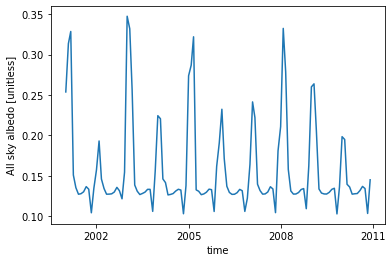

In [39]:
ds.ASA.plot()

<div class="alert alert-block alert-info">
    The package <i> xarray </i> automatically sets the x and y axis names based on the metadata/attributes that are set for each variable. Notice that above we set the <code>long_name</code> and <code>units</code> for our new variable <code>ASA</code>, which is how <i>xarray</i> knew what to put in the y-axis label.
</div>


We can also just plot one year of data (2001) from the simulation, selecting the year using the `.sel` function. Note we also changed the color and marker for this plot.

*More plotting examples are on the [xarray web site](https://docs.xarray.dev/en/latest/user-guide/plotting.html)*

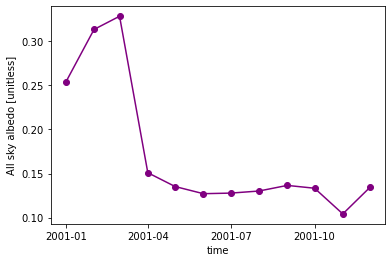

In [84]:
ds.ASA.sel(time='2001').plot(color="purple", marker="o")

We can plot multiple graphs by using the keyword `ax`. Here, `axes` is an array we create consisting of a left and right axis created with `plt.subplots`.

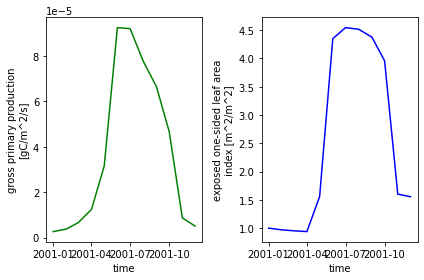

In [94]:
fig, axes = plt.subplots(ncols=2)
ds.GPP.sel(time='2001').plot(ax=axes[0], color='green')
ds.ELAI.sel(time='2001').plot(ax=axes[1], color='blue')
plt.tight_layout()

What if we wanted to compare years? We can start by creating columns for our years. The `time.dt` accessor allows us to access DateTime information. Next we will create a `groupby` object across our years. We will use this grouping to plot each year.

*For more information about working with time in xarray, see the [xarray documentation](https://xarray.pydata.org/en/v0.11.0/time-series.html).*

Text(0, 0.5, 'Albedo [unitless]')

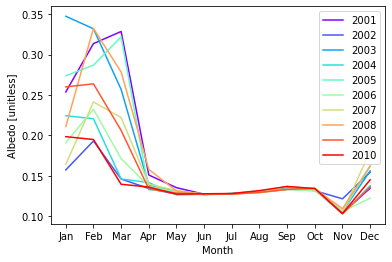

In [95]:
# create month and year columns
ds["year"] = ds.time.dt.year
ds["month_name"] = ds.time.dt.strftime("%b")

# group by year
groups = ds.groupby("year")

# plot each year
colors = plt.cm.rainbow(np.linspace(0, 1, 10))
for count, group in enumerate(groups):
    year = group[0]
    df = group[1]
    plt.plot(df.month_name, df.ASA, label=year, color=colors[count])
plt.legend(loc='upper right')
plt.xlabel("Month")
plt.ylabel("Albedo [unitless]")

We can also plot a histogram across all years from the summer (June, July, and August). This is done by using `.dt` and the `.isin` accessors to subset the data (`time.dt.month.isin([6, 7, 8])`).

(array([ 4., 10.,  6.,  0.,  1.,  2.,  4.,  1.,  1.,  1.]),
 array([0.1265587 , 0.12706295, 0.12756717, 0.12807141, 0.12857564,
        0.12907988, 0.12958412, 0.13008834, 0.13059258, 0.13109681,
        0.13160105], dtype=float32),
 <BarContainer object of 10 artists>)

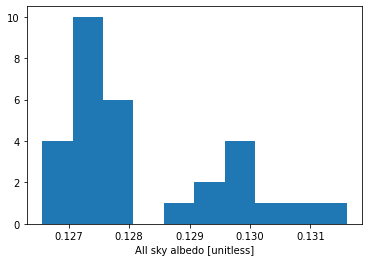

In [96]:
ds.ASA.isel(time=(ds.time.dt.month.isin([6, 7, 8]))).plot.hist()

### 3.2 Plotting in multiple dimensions
When the data is two-dimensional, by default *xarray* calls `xarray.plot.pcolormesh()`.

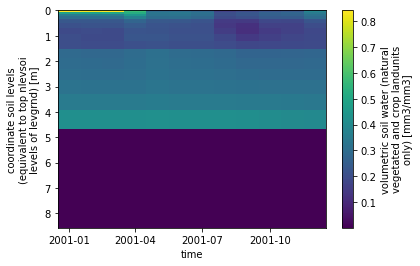

In [117]:
# pcolormesh plot
ds.sel(time='2001').H2OSOI.plot(x='time', yincrease=False)

We can also make a contour plot:

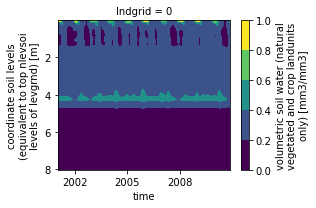

In [118]:
ds.H2OSOI.plot.contourf(col='lndgrid', x='time', yincrease=False)

<div class="alert alert-block alert-warning">
<b>CHALLENGE:</b> Instead of a contour plot, can you plot the volumetric soil water (<code>H2OSOI</code>) for year 2001 as a linegraph, where each line is a different <code>levsoi</code> value? (<i> Hint: check out the <code>hue</code> parameter for plotting in xarray</i>).
</div>

In [ ]:
# plot your graph here


### 3.3 Visualizing Relationships

Plotting can be useful for looking at relationships between different variables. What do you expect the relationship between latent heat flux and GPP to be? Below we are breaking up the data by season (`time.dt.season` is a built-in accessor).

Text(0, 0.5, 'GPP [gC m$^{-2}$ s$^{-1}$]')

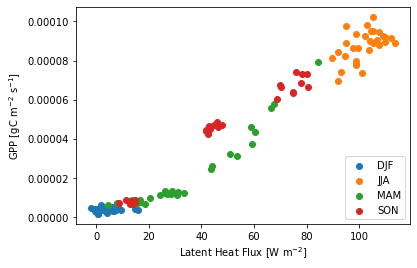

In [124]:
ds["season"] = ds.time.dt.season
grouped = ds.groupby('season')
for key, group in grouped:
    plt.scatter(group.EFLX_LH_TOT, group.GPP, label=key)
plt.legend(loc="lower right")
plt.xlabel("Latent Heat Flux [W m$^{-2}$]")
plt.ylabel("GPP [gC m$^{-2}$ s$^{-1}$]")

**Questions:** 
- How is albedo related to GPP?
- How does this relationship play out over different seasons?

**What other relationships can you elucidate from these simulations?**

In [ ]:
# plot some relationships here


---
## 4. Aggregating and averaging
### 4.1 Basic aggregation methods

Often we will want to aggregate our simulations from monthly to yearly or larger sums or averages. There are various ways to do this using *xarray*. A very common step would be to apply some function over the whole dataset, such as `sum()`, `mean()`, `min()`, or `max()`. Let's explore some of these methods.

In [126]:
# compute the average GPP across the whole time series
ds.GPP.mean().values

array(3.8232996e-05, dtype=float32)

Let's also calculate the average GPP for a specific year.

In [127]:
# calculate GPP for year 2005
ds.sel(time='2005').GPP.mean().values

array(3.589444e-05, dtype=float32)

**Can you find the maximum soil volumetric water content for the soil at 0.26 m?**

In [138]:
# calculate answer here


### 4.2 Split-Apply-Combine
You saw in our plotting above that we used *xarray*'s `.groupby` function to group our dataset by a specific variable (in that instance, years). This `groupy` operation allows us to aggregate our data conditionally on some coordinate label or group. This then allows us to perform **split / apply / combine** methods on *xarray* DataArrays and Datasets:

* **Splitting** the dataset into groups based on some criteria
* **Applying** a function to each of those groups (e.g. aggregating, performing a transform, or filtering)
* **Combining** the results back into one data structure

Let's use this methodology to remove seasonality from our dataset.

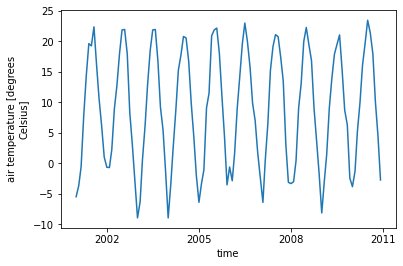

In [154]:
# calculate temperature in Celsius
ds['tair'] = ds.TBOT - 273.15
ds['tair'].attrs['units'] = 'degrees Celsius'
ds['tair'].attrs['long_name'] = 'air temperature'

# plot temperature across whole time series
ds.tair.plot()

First we will split the data by month:

In [152]:
ds.tair.groupby(ds.time.dt.month)

DataArrayGroupBy, grouped over 'month'
12 groups with labels 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12.

Now we can apply a calculation to each group - either an aggregation function, which will reduce the size of the group, or a transformation, which will preserve the group's full size. Here we will take an average. Notice that the dimensions are now 1 x 12, because we have averaged across all years for each month.

In [155]:
# split-apply-combine
t_clim = ds.tair.groupby(ds.time.dt.month).mean()
t_clim

<xarray.DataArray 'tair' (month: 12, lndgrid: 1)>
dask.array<stack, shape=(12, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * month    (month) int64 1 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lndgrid

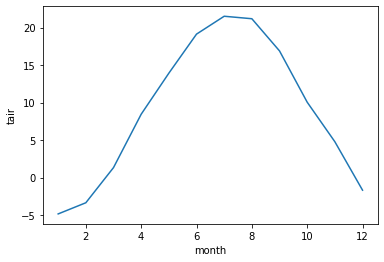

In [156]:
t_clim.plot()

If we combine steps we can use these methods to remove the seasonality from our original dataset. Note here that the dataset is now 1 x 120 in dimension.

In [157]:
gb = ds.tair.groupby(ds.time.dt.month)
t_anom = gb - gb.mean(dim = 'time')
t_anom

<xarray.DataArray 'tair' (time: 120, lndgrid: 1)>
dask.array<getitem, shape=(120, 1), dtype=float32, chunksize=(1, 1), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) object 2001-01-01 00:00:00 ... 2010-12-01 00:00:00
    month    (time) int64 1 2 3 4 5 6 7 8 9 10 11 ... 2 3 4 5 6 7 8 9 10 11 12
Dimensions without coordinates: lndgrid

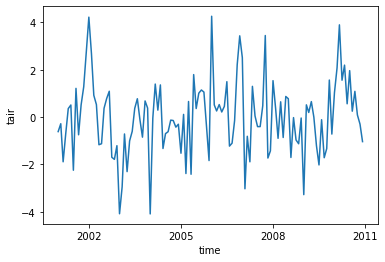

In [158]:
t_anom.plot()

We can also calculate rolling means using the `rolling` function. Here we will calculate a 6-month rolling average of GPP.

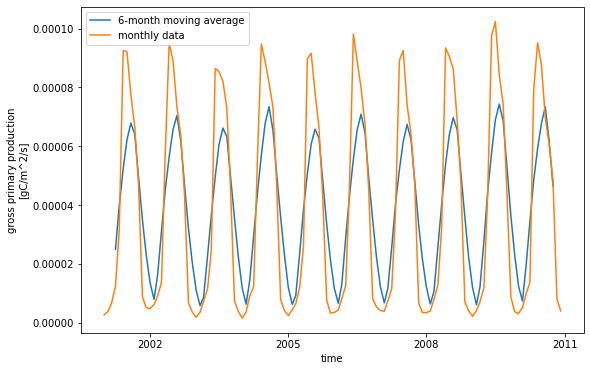

In [176]:
mv_avg = ds.GPP.rolling(time=6, center=True).mean()
mv_avg.plot(size = 6)
ds.GPP.plot()
plt.legend(['6-month moving average', 'monthly data'])

<div class="alert alert-block alert-warning">
<b>CHALLENGE:</b> Calculate the average seasonal GPP values.
</div>